## Business Understanding

- The stakeholder is HelloFresh
- It is important to capture the sentiment of your customers for a couple of reasons.
1. To build a great reputation and track record that you are a good company that others should be using.
2. That you use customers' negative feedback to look into potential problems and see if there is any truth to that feedback.
- Most of the time this feedback is given in a standard review format with a certain amount of stars and the review text.
- **However, there are times when a customer will just give feedback with no number of stars. You can be losing valuable reviews!!** 
- **There are also times when feedback is not given in the standard way. It can be given through a support call or email.** 
    - **It is important to also capture the sentiment of the text transcripts of these calls and the emails.**
- HelloFresh can use a sentimental analysis from a natural language processing model to capture these missed sentiments to help cast a wider net on reviews which can overall help company performance and reputation.


## Data Understanding

- The data I received comes from [Trustpilot](https://www.trustpilot.com/review/hellofresh.com). Trustpilot is an online review community that connects businesses and consumers through genuine feedback from customers about their buying and service experiences. 
- The raw data from Trustpilot is important because to be able to run a sentimental analysis, you need a good amount of reviews of text and a target.
- There are over 40,000 reviews which give me more than plenty of data to make a NLP model.
- Aside from the text, I used topic modeling to make the data more robust and try and find deeper underlying reasons.

## Web Scraping

In [1]:
# Importing the packages needed for webscraping
from bs4 import BeautifulSoup
import requests
import time
import pandas as pd

In [2]:
# Function to scrape the pages on the trust pilot site for the text of the review and the star rating
# This Function starts on the second page of reviews and can go up to any number of pages
def scrape_review_pages(page_start, page_end):
    headers = {'user-agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36"}
    reviews = []
    for i in range(page_start, page_end):
        url = 'https://www.trustpilot.com/review/hellofresh.com?page=' + str(i)
        try:
            html_page = requests.get(url, headers = headers)
            html_page.raise_for_status()
            soup = BeautifulSoup(html_page.content, 'html.parser')
            # gave access to all review cards
            review_elements = soup.find_all("article", class_="styles_reviewCard__hcAvl")
            for review_element in review_elements:
                # gave access to all review text
                review_text = review_element.find("p", class_="typography_body-l__KUYFJ")
                if review_text is not None:
                    review_text = review_text.text.strip()
                else:
                    review_text = "No review text available."
                review_score_tag = review_element.find("div", class_="star-rating_starRating__4rrcf")
                if review_score_tag is not None:
                    # took the star rating and gave a score
                    review_score = int(review_score_tag.img['alt'].split()[1])
                else:
                    review_score = 0
                review_object = {"text": review_text, "score": review_score}
                reviews.append(review_object)
            # sleep time allows the website resources time preventing it from crashing
            time.sleep(3)
        except requests.exceptions.RequestException as e:
            print(f"Error fetching page {i}: {e}")
            continue
    return reviews

**Time to scrape**

In [3]:
# Have to scrape the website in batches so it does not crash
# This will take a while
Hello_fresh_reviews = scrape_review_pages(2,275)
hf2 = scrape_review_pages(275,447)
hf3 = scrape_review_pages(447, 597)
hf4 = scrape_review_pages(597, 747)
hf5 = scrape_review_pages(747,900)
hf6 = scrape_review_pages(900,1100)
hf7 = scrape_review_pages(1100,1275)
hf8 = scrape_review_pages(1275,1475)
hf9 = scrape_review_pages(1475,1675)
hf10 = scrape_review_pages(1675,1875)
hf11 = scrape_review_pages(1875,2075)
hf12 = scrape_review_pages(2075,2200)
hf13 = scrape_review_pages(2200,2346)

In [6]:
# Saving each batch as a DataFrame
df = pd.DataFrame(Hello_fresh_reviews)
df2 = pd.DataFrame(hf2)
df3 = pd.DataFrame(hf3)
df4 = pd.DataFrame(hf4)
df5 = pd.DataFrame(hf5)
df6 = pd.DataFrame(hf6)
df7 = pd.DataFrame(hf7)
df8 = pd.DataFrame(hf8)
df9 = pd.DataFrame(hf9)
df10 = pd.DataFrame(hf10)
df11 = pd.DataFrame(hf11)
df12 = pd.DataFrame(hf12)
df13 = pd.DataFrame(hf13)

In [7]:
# Concatenating all the DataFrames
fresh_df = pd.concat([df, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13], 0)

In [10]:
# Resetting the index so that it is continuos
hello_fresh_df = fresh_df.reset_index(drop = True)

In [11]:
# Dropping all of the rows that have "No review text available."
hello_fresh_df = hello_fresh_df.drop(hello_fresh_df[hello_fresh_df['text'] == "No review text available."].index)

In [12]:
# Resetting the index again
hello_fresh_df = hello_fresh_df.reset_index(drop=True)

In [13]:
# Changing the numeric star rating to positive/neutral/negative sentiments
changing_numeric_tosentiment = {1: "negative", 
                                2: "negative", 
                                3: "neutral", 
                                4: "positive", 
                                5: "positive" }
hello_fresh_df['score'] = hello_fresh_df['score'].replace(changing_numeric_tosentiment)

In [16]:
# Saving the dataframe to a csv
hello_fresh_df.to_csv("hello_fresh_reviews.csv")

**Important to save as a csv so you do not have to go through scraping process again!**

## Topic Modeling - Unsupervised Learning

In [105]:
# Importing packages need for topic modeling (Pandas has already been uploaded)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re  
import nltk 
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

In [106]:
# Loading in the saved csv from web scraping and saving it to a Data Frame
hello_df = pd.read_csv("hello_fresh_reviews.csv").drop(columns = 'Unnamed: 0')

In [107]:
# Creating a function to preprocess my text to get ready for topic modeling and NLP
def process_text(text, min_length):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    text_lower = text.lower()

    # remove mentions, hashtags, and urls, strip whitspace and breaks
    text_lower = re.sub(r"@[a-z0-9_]+|#[a-z0-9_]+|http\S+", "", text_lower).strip().replace("\r", "").replace("\n", "").replace("\t", "")
    
    
    # remove stop words and punctuations 
    text_norm = [x for x in word_tokenize(text_lower) if ((x.isalpha()) & (x not in stop_words)) ]

    # POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(text_norm))) 

    # now we are going to have a cutoff here. any tokenized cocument with length < min length will be removed from corpus
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
        text_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
        return text_norm

In [108]:
# Applying the preprocessing function to the text part of the Data Frame
hello_df['text'] = hello_df['text'].apply(process_text, args = [5])

In [109]:
# Getting rid of any rows that might have been wiped out from cleaning
hello_fresh_new = hello_df[hello_df['text'] != '']

In [110]:
# Resetting index
hello_fresh_new = hello_fresh_new.reset_index(drop = True)

In [111]:
# Creating a corupus and vectorizing it
corpus = hello_fresh_new['text']
vectorizer = TfidfVectorizer()
corpus_vectorized = vectorizer.fit_transform(corpus)

In [112]:
# Instantiating NMF and fitting the vectorized corpus
topic_model = NMF(n_components = 4, max_iter = 1000)
topic_model.fit(corpus_vectorized)

NMF(max_iter=1000, n_components=4)

In [113]:
# H encodes the weight of the fitted topics for each document
# W encodes the importance of each token in the fitted topics
H = topic_model.transform(corpus_vectorized)
W = topic_model.components_

In [114]:
# For loop gives us words with the heighest weights for each topic
for index,topic in enumerate(W):
    print(f'THE TOP 25 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 25 WORDS FOR TOPIC #0
['together', 'plan', 'get', 'grocery', 'variety', 'thing', 'prepare', 'everything', 'fun', 'husband', 'much', 'family', 'really', 'delicious', 'eat', 'dinner', 'week', 'try', 'new', 'hellofresh', 'enjoy', 'make', 'love', 'cook', 'meal']


THE TOP 25 WORDS FOR TOPIC #1
['call', 'go', 'meat', 'produce', 'give', 'cancel', 'use', 'credit', 'quality', 'great', 'day', 'ingredient', 'receive', 'miss', 'issue', 'food', 'week', 'order', 'get', 'time', 'good', 'delivery', 'customer', 'box', 'service']


THE TOP 25 WORDS FOR TOPIC #2
['simple', 'quick', 'selection', 'variety', 'choice', 'everything', 'portion', 'fresh', 'tasty', 'always', 'ingredient', 'excellent', 'make', 'direction', 'taste', 'prepare', 'quality', 'good', 'instruction', 'delicious', 'follow', 'food', 'great', 'recipe', 'easy']


THE TOP 25 WORDS FOR TOPIC #3
['life', 'month', 'dinner', 'healthy', 'happy', 'friend', 'time', 'try', 'produce', 'year', 'absolutely', 'best', 'thank', 'recipe', 'highly',

In [115]:
%%capture topic_word_plot
# Function that outputs the most important words and weights for each topic
def plot_top_words(W, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 4, figsize=(15, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
tfidf_feature_names = vectorizer.get_feature_names()
plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in NMF model")

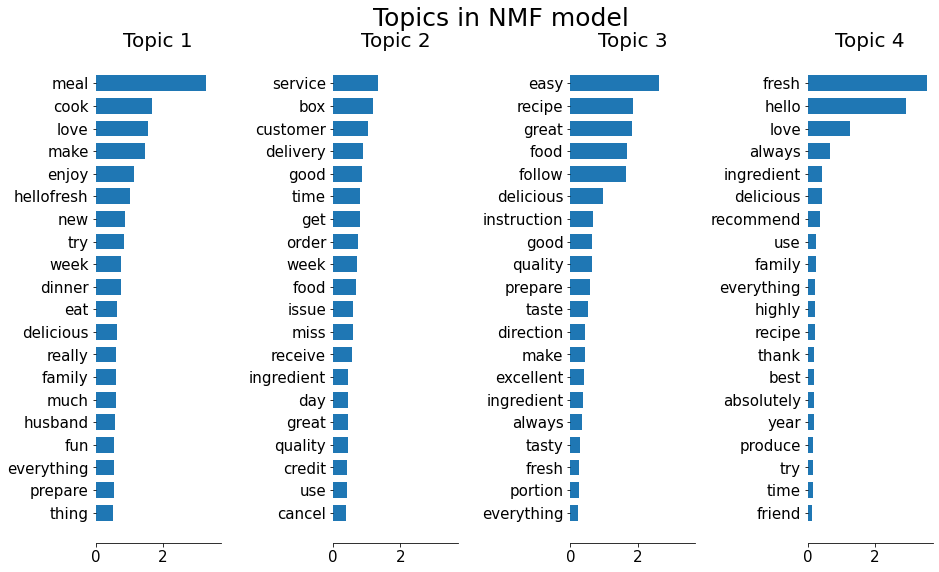

In [116]:
# Visualizing the function
topic_word_plot()

In [117]:
# Naming each topic
topic_name_dict = {0: 'Culinary_experience', 1: 'Delivery_Service', 2: 'Recipe_Instructions', 3: 'General'}

In [118]:
# Takes in list of documents and plots topic weight vectors for each document
def text_topbreakdown(locator):

    print(hello_df.loc[locator].text)
    int_index = corpus.index.get_loc(locator)

    topic_keys = topic_name_dict.values()
    zipped_tuple = list(zip(topic_keys, list(H[int_index,:])))

    topic_breakdown = pd.DataFrame(zipped_tuple, columns = ['Topic', 'Weight']).set_index(['Topic'])
    topic_breakdown['Normalized weight'] = topic_breakdown['Weight']/topic_breakdown['Weight'].sum()

    sns.barplot(y = topic_breakdown.index, x = 'Normalized weight', data = topic_breakdown)
    plt.title("Distribution of topics for tweet no. " + str(locator))
    plt.show()

    return topic_breakdown

hello fresh amazing busy schedule recipe easy make food delicious take pause simply hot live box tend sit delivery truck long time


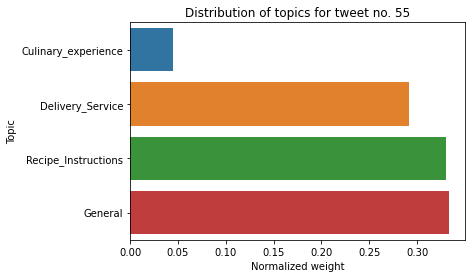

get order call talk someone anything fix meal great


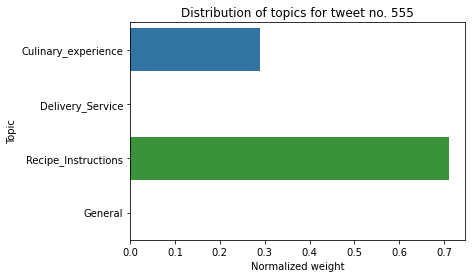

food always delicious get try new flavor


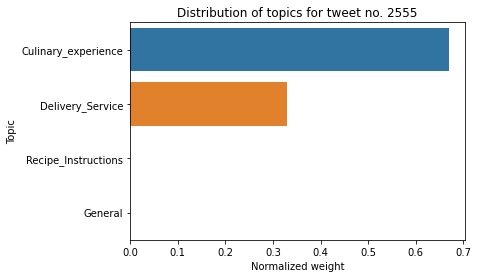

much meal much unneccessary work produce sub par


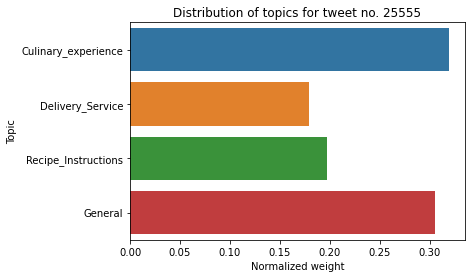

In [119]:
# Making a list of random tweets and seeing their topic probabilities
text_list = [55,555,2555, 25555]
viz = list(map(text_topbreakdown, text_list))

In [120]:
tsne = TSNE(random_state=24, learning_rate=100)
tsne_trans = tsne.fit_transform(H)
tsne_trans = pd.DataFrame(tsne_trans, columns = ['TSNE1', 'TSNE2'])

In [121]:
# For each document takes the topic with highest weight and assigns document to this class -- hard clustering.
tsne_trans['class'] = np.argmax(H, axis = 1)
tsne_trans['class'] = tsne_trans['class'].replace(topic_name_dict)

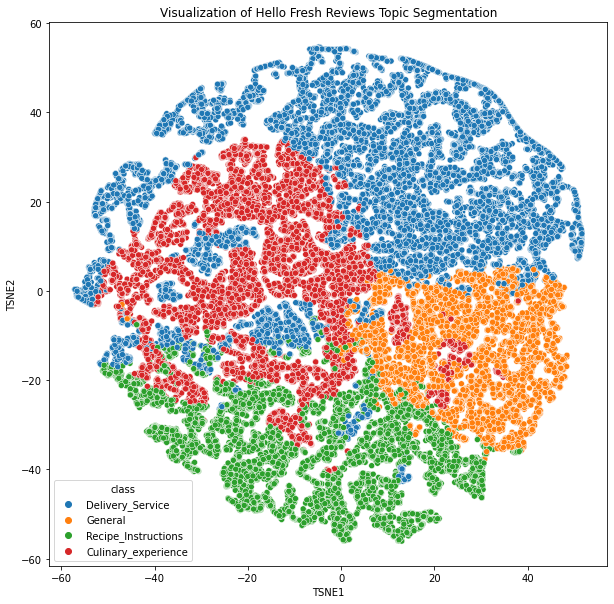

In [122]:
# Segmenting each topic
plt.figure(figsize=(10,10))
sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'class', data = tsne_trans, palette = 'tab10')
plt.title('Visualization of Hello Fresh Reviews Topic Segmentation')
plt.show()

In [123]:
# Saving the probabilities of each topic for a tweet
H_repres_norm = pd.DataFrame(H, columns = topic_name_dict.values(), index = hello_fresh_new.index)
H_repres_norm = H_repres_norm.divide(H_repres_norm.sum(axis=1), axis=0)

In [124]:
# Joining the text dataframe and the topic modeling
hf_topic_model_df = hello_fresh_new.join(H_repres_norm).dropna()
hf_topic_model_df = hf_topic_model_df.reset_index(drop = True)
hf_topic_model_df.head()

,text,score,Culinary_experience,Delivery_Service,Recipe_Instructions,General
0,edit tuesday luck even put together ship app a...,negative,0.023924,0.962666,0.000000,0.013410
1,trouble gift card call customer support expect...,positive,0.004714,0.995286,0.000000,0.000000
2,recipe great produce always fresh sometimes ru...,positive,0.000000,0.303548,0.348214,0.348238
3,delivery good believe package good farmer mark...,positive,0.295667,0.701070,0.000000,0.003263
4,great quality food simple instruction add easy...,positive,0.216712,0.217963,0.565325,0.000000


In [28]:
# Saved to CSV
hf_topic_model_df.to_csv('hello_fresh_preprocessed_topic_model.csv')

## NLP Modeling

In [3]:
# Upload CSV
data_set = pd.read_csv('hello_fresh_preprocessed_topic_model.csv').drop(columns = "Unnamed: 0")

In [14]:
# Import packages necessary for modeling 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier

In [5]:
# Looking at the info
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40806 entries, 0 to 40805
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   text                 40806 non-null  object 
 1   score                40806 non-null  object 
 2   Culinary_experience  40806 non-null  float64
 3   Delivery_Service     40806 non-null  float64
 4   Recipe_Instructions  40806 non-null  float64
 5   General              40806 non-null  float64
dtypes: float64(4), object(2)
memory usage: 1.9+ MB


In [6]:
# Changing the multiclass to binary classification
changing_neutral_negative = {'neutral': "negative"}
data_set['score'] = data_set['score'].replace(changing_neutral_negative)

In [7]:
X = data_set.drop(columns = 'score')
y = data_set['score']

In [34]:
# Imbalanced target variable
y.value_counts()

positive    33341
negative     7465
Name: score, dtype: int64

In [9]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 24)

### First Simple Model (fsm) Logistic Regression

In [50]:
# Creating a pipeline for my first simple model
text_transformer = Pipeline(steps = [
    ("squeeze", FunctionTransformer(lambda x: x.squeeze())),
    ("vec", CountVectorizer()),
    ("array", FunctionTransformer(lambda x: x.toarray()))
])

numeric_transformer = Pipeline(steps = [
    ("scale", StandardScaler())
])

preprocessor = ColumnTransformer(transformers = [
    ('review_text', text_transformer, ['text']), 
    ('num', numeric_transformer, ['Culinary_experience', 'Delivery_Service', 'Recipe_Instructions', 'General'])
])

steps = [('preprocessor', preprocessor), 
         ('rus', RandomUnderSampler(random_state = 24, sampling_strategy = 'majority')), 
         ('log', LogisticRegression(random_state = 24, max_iter = 1000))]
fsmodel = Pipeline(steps)

In [51]:
# Fitting the model
fsmodel.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('review_text',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x0000026D77B358B0>)),
                                                                  ('vec',
                                                                   CountVectorizer()),
                                                                  ('array',
                                                                   FunctionTransformer(func=<function <lambda> at 0x0000026D77B350D0>))]),
                                                  ['text']),
                                                 ('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                             

In [52]:
# Models train accuracy score
fsmodel.score(X_train, y_train)

0.9006441674835457

In [53]:
# Predicting on the test set and a break down of metrics
fsm_y_pred = fsmodel.predict(X_test)
print(classification_report(y_test, fsm_y_pred))

              precision    recall  f1-score   support

    negative       0.61      0.86      0.72      2232
    positive       0.97      0.88      0.92     10010

    accuracy                           0.87     12242
   macro avg       0.79      0.87      0.82     12242
weighted avg       0.90      0.87      0.88     12242



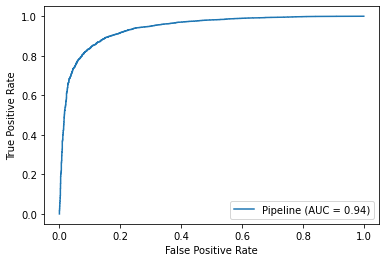

In [54]:
# Plotting the ROC curve
plot_roc_curve(fsmodel, X_test, y_test);

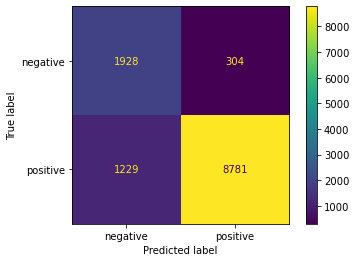

In [55]:
# Confusion matrix
plot_confusion_matrix(fsmodel, X_test,
                      y_test);

**Logistic Regression seems to work relatively well for the recall and accuracy scores. It seems to have trouble with precision of negative scores. This can be due to the nature of the 3 star or neutral ratings that arent always positive but have some positive notions along with negative. The AUC score is also very high with 94%.**

### Hyper Parameter Tuning Logistic Regression

In [141]:
# Hyper Parameter tuning 
log_param_grid = {
    'log__C': [.1, .5, 1.0],
    'log__penalty': ['l2'],
    'log__solver': ['liblinear', 'lbfgs'],
    'log__max_iter': [10000]
}
loggridsearch = GridSearchCV(fsmodel, log_param_grid, scoring = 'accuracy', cv = 4)

In [142]:
loggridsearch.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('review_text',
                                                                         Pipeline(steps=[('squeeze',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x0000026D77B358B0>)),
                                                                                         ('vec',
                                                                                          CountVectorizer()),
                                                                                         ('array',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x0000026D77B350D0>))]),
                                                                         ['text']),
                        

In [146]:
Log_grid_best = loggridsearch.best_estimator_
Log_grid_best.score(X_train,y_train)

0.8978084301918499

In [147]:
log_y_pred = Log_grid_best.predict(X_test)
print(classification_report(y_test, log_y_pred))

              precision    recall  f1-score   support

    negative       0.61      0.87      0.72      2232
    positive       0.97      0.88      0.92     10010

    accuracy                           0.88     12242
   macro avg       0.79      0.87      0.82     12242
weighted avg       0.90      0.88      0.88     12242



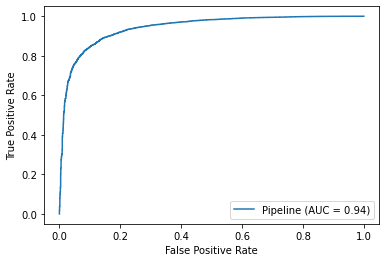

In [149]:
# Plotting the ROC curve
plot_roc_curve(Log_grid_best, X_test, y_test);

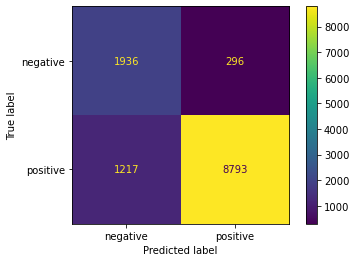

In [148]:
# Confusion matrix
plot_confusion_matrix(Log_grid_best, X_test,
                      y_test);

**Hyper Parameter tuning did not help much with the score as the same parameters were used as the defualt parameters. Nevertheless I will try and get better scores using a different classifier.**

### Random Forest Model

In [58]:
# Setting up pipelines for random forest model
text_transformer = Pipeline(steps = [
    ("squeeze", FunctionTransformer(lambda x: x.squeeze())),
    ("vec", CountVectorizer()),
    ("array", FunctionTransformer(lambda x: x.toarray()))
])

numeric_transformer = Pipeline(steps = [
    ("scale", StandardScaler())
])

preprocessor = ColumnTransformer(transformers = [
    ('review_text', text_transformer, ['text']), 
    ('num', numeric_transformer, ['Culinary_experience', 'Delivery_Service', 'Recipe_Instructions', 'General'])
])

steps = [('preprocessor', preprocessor), 
         ('rus', RandomUnderSampler(random_state = 24, sampling_strategy = 'majority')), 
         ('randfor', RandomForestClassifier(random_state = 24, max_depth = 6))]
rfmodel = Pipeline(steps)

In [59]:
# fitting the model
rfmodel.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('review_text',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x0000026D7808B550>)),
                                                                  ('vec',
                                                                   CountVectorizer()),
                                                                  ('array',
                                                                   FunctionTransformer(func=<function <lambda> at 0x0000026D7808B3A0>))]),
                                                  ['text']),
                                                 ('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                             

In [60]:
# Training accuracy score
rfmodel.score(X_train, y_train)

0.8418988937123653

In [61]:
# Test metrics 
rf_y_pred = rfmodel.predict(X_test)
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

    negative       0.55      0.80      0.65      2232
    positive       0.95      0.85      0.90     10010

    accuracy                           0.84     12242
   macro avg       0.75      0.83      0.77     12242
weighted avg       0.88      0.84      0.85     12242



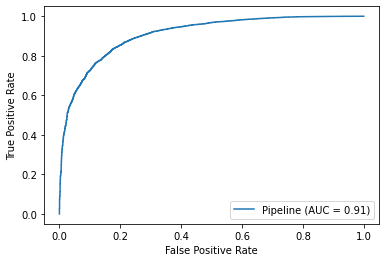

In [62]:
# Plotting ROC Curve
plot_roc_curve(rfmodel, X_test, y_test);

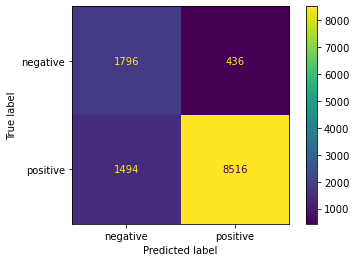

In [63]:
# Confusion Matrix
plot_confusion_matrix(rfmodel, X_test,
                      y_test);

**The scores and overall performance of the base random forest were not as good as logistic regression. I am going to try and hyper parameter tune random forest to get a better model.**

### Hyper Parameter Tuning Random Forest

In [66]:
# Random searching to hone in on best parameters
rfgridparams =  [{'randfor__max_depth' : [4,5,6,7,8],
                  'randfor__n_estimators' : [100, 150, 200],
                  'randfor__min_samples_split': [2,5, 6, 8],
                  'randfor__min_samples_leaf': [1, 3, 6, 8]}]
rfrandomsearch = RandomizedSearchCV(rfmodel, rfgridparams, scoring= 'accuracy', cv = 3)

In [67]:
# Fitting
rfrandomsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('review_text',
                                                                               Pipeline(steps=[('squeeze',
                                                                                                FunctionTransformer(func=<function <lambda> at 0x0000026D7808B550>)),
                                                                                               ('vec',
                                                                                                CountVectorizer()),
                                                                                               ('array',
                                                                                                FunctionTransformer(func=<function <lambda> at 0x0000026D7808B3A0>))]),
                                                      

In [68]:
# Creating a dataframe that shows the top 5 best models from RandomSearchCV
randomcv_results = pd.DataFrame(rfrandomsearch.cv_results_)
randomcv_results.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randfor__n_estimators,param_randfor__min_samples_split,param_randfor__min_samples_leaf,param_randfor__max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,6.472644,0.037347,0.889025,0.019822,100,8,6,8,"{'randfor__n_estimators': 100, 'randfor__min_s...",0.862529,0.865035,0.856738,0.861434,0.003475,1
4,5.796254,0.033836,0.870419,0.021265,100,5,6,7,"{'randfor__n_estimators': 100, 'randfor__min_s...",0.863684,0.863355,0.853272,0.860104,0.004833,2
3,9.037510,0.012022,0.952329,0.024781,200,2,6,6,"{'randfor__n_estimators': 200, 'randfor__min_s...",0.858328,0.863145,0.857053,0.859509,0.002623,3
6,6.713581,0.020403,0.890850,0.013327,200,5,3,4,"{'randfor__n_estimators': 200, 'randfor__min_s...",0.860639,0.869131,0.848335,0.859368,0.008537,4
9,8.979763,0.308807,0.928904,0.042455,150,8,6,8,"{'randfor__n_estimators': 150, 'randfor__min_s...",0.858118,0.862199,0.855582,0.858633,0.002726,5


In [69]:
# Using the randomsearch params to grid search
rfgridsearchparams =  [{'randfor__max_depth' : [4,6,7,8],
                  'randfor__n_estimators' : [100, 200],
                  'randfor__min_samples_split': [2, 3, 5, 8],
                  'randfor__min_samples_leaf': [ 3, 4, 6]}]
rfgridsearch = GridSearchCV(rfmodel, rfgridsearchparams, scoring= 'accuracy', cv = 3)

In [70]:
# Fitting
rfgridsearch.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('review_text',
                                                                         Pipeline(steps=[('squeeze',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x0000026D7808B550>)),
                                                                                         ('vec',
                                                                                          CountVectorizer()),
                                                                                         ('array',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x0000026D7808B3A0>))]),
                                                                         ['text']),
                        

In [74]:
# Train accuracy
rf_best_model = rfgridsearch.best_estimator_
rf_best_model.score(X_train, y_train)

0.8452947766419269

In [75]:
# Test metrics
rf_tune_y_pred = rf_best_model.predict(X_test)
print(classification_report(y_test, rf_tune_y_pred))

              precision    recall  f1-score   support

    negative       0.56      0.80      0.66      2232
    positive       0.95      0.86      0.90     10010

    accuracy                           0.85     12242
   macro avg       0.75      0.83      0.78     12242
weighted avg       0.88      0.85      0.86     12242



**The model performed slightly better than the base random forest model but still not as good as the logistic regression.**

### XGBoost Model

In [76]:
# Creating a pipeline for XGBoost model
text_transformer = Pipeline(steps = [
    ("squeeze", FunctionTransformer(lambda x: x.squeeze())),
    ("vec", CountVectorizer()),
    ("array", FunctionTransformer(lambda x: x.toarray()))
])

numeric_transformer = Pipeline(steps = [
    ("scale", StandardScaler())
])

preprocessor = ColumnTransformer(transformers = [
    ('review_text', text_transformer, ['text']), 
    ('num', numeric_transformer, ['Culinary_experience', 'Delivery_Service', 'Recipe_Instructions', 'General'])
])

steps = [('preprocessor', preprocessor), 
         ('rus', RandomUnderSampler(random_state = 24, sampling_strategy = 'majority')), 
         ('xgb', XGBClassifier(random_state = 24))]
xgbmodel = Pipeline(steps)

In [77]:
# Fitting
xgbmodel.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('review_text',
                                                  Pipeline(steps=[('squeeze',
                                                                   FunctionTransformer(func=<function <lambda> at 0x0000026CB35D65E0>)),
                                                                  ('vec',
                                                                   CountVectorizer()),
                                                                  ('array',
                                                                   FunctionTransformer(func=<function <lambda> at 0x0000026CB35D6310>))]),
                                                  ['text']),
                                                 ('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                             

In [45]:
# Train accuracy
xgbmodel.score(X_train, y_train)

0.9281263128413387

In [46]:
# Test metrics
xgb_y_pred = xgbmodel.predict(X_test)
print(classification_report(y_test, xgb_y_pred))

              precision    recall  f1-score   support

    negative       0.64      0.82      0.72      2232
    positive       0.96      0.90      0.93     10010

    accuracy                           0.88     12242
   macro avg       0.80      0.86      0.82     12242
weighted avg       0.90      0.88      0.89     12242



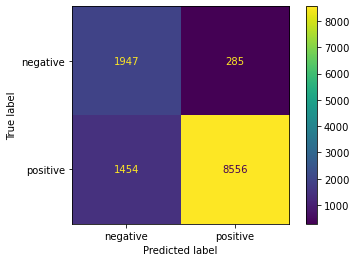

In [98]:
# Confusion matrix
plot_confusion_matrix(xgbmodel, X_test,
                      y_test);

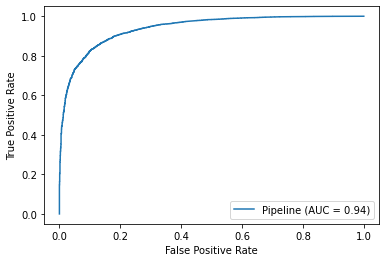

In [128]:
# Plotting ROC curve
plot_roc_curve(xgbmodel, X_test, y_test);

**Accuracy scores were on par with the logistic regression. There was a difference in recall and precision scores compared to logistic regression.**

### Hyper Parameter Tuning XGBoost

In [126]:
# Hyper parameters for xgboost
xgb_paramgrid = {
    'xgb__learning_rate': [0.05, 0.1, 0.3],
    'xgb__max_depth': [3, 5, 6],
    'xgb__n_estimators': [100, 200],
    'xgb__colsample_bytree': [.6, .8, 1],
    'xgb__gamma': [0, 10, 50]
}
xgb_gridsearch = RandomizedSearchCV(xgbmodel, xgb_paramgrid, scoring = 'accuracy', cv = 4)

In [129]:
# Fitting
xgb_gridsearch.fit(X_train, y_train)

RandomizedSearchCV(cv=4,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('review_text',
                                                                               Pipeline(steps=[('squeeze',
                                                                                                FunctionTransformer(func=<function <lambda> at 0x0000026CB35D65E0>)),
                                                                                               ('vec',
                                                                                                CountVectorizer()),
                                                                                               ('array',
                                                                                                FunctionTransformer(func=<function <lambda> at 0x0000026CB35D6310>))]),
                                                      

In [138]:
# Creating a dataframe that shows the top 5 best models from RandomSearchCV
xgb_randomcv_results = pd.DataFrame(xgb_gridsearch.cv_results_)
xgb_randomcv_results.sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgb__n_estimators,param_xgb__max_depth,param_xgb__learning_rate,param_xgb__gamma,param_xgb__colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
2,28.999828,0.474488,2.022994,0.044768,100,6,0.3,0,0.8,"{'xgb__n_estimators': 100, 'xgb__max_depth': 6...",0.861784,0.855202,0.857303,0.862904,0.859298,0.003160,1
7,40.991433,1.108229,2.087464,0.059220,200,5,0.3,10,0.6,"{'xgb__n_estimators': 200, 'xgb__max_depth': 5...",0.846940,0.842459,0.839798,0.841199,0.842599,0.002677,2
4,29.258334,0.326830,1.998442,0.015604,100,6,0.1,10,0.8,"{'xgb__n_estimators': 100, 'xgb__max_depth': 6...",0.844139,0.835877,0.838398,0.842319,0.840183,0.003238,3
6,69.499804,2.195243,2.098917,0.052290,200,6,0.05,10,1,"{'xgb__n_estimators': 200, 'xgb__max_depth': 6...",0.836578,0.834197,0.831116,0.840779,0.835667,0.003530,4
1,27.882206,0.470832,1.990268,0.039469,100,6,0.05,10,0.8,"{'xgb__n_estimators': 100, 'xgb__max_depth': 6...",0.835317,0.830556,0.829296,0.835737,0.832727,0.002840,5


In [150]:
xgb_rand_best = xgb_gridsearch.best_estimator_

In [136]:
xgb_rand_best.score(X_train, y_train)

0.8876207814031648

In [135]:
xgb_rand_y_pred = xgb_rand_best.predict(X_test)
print(classification_report(y_test, xgb_rand_y_pred))

              precision    recall  f1-score   support

    negative       0.58      0.86      0.69      2232
    positive       0.97      0.86      0.91     10010

    accuracy                           0.86     12242
   macro avg       0.77      0.86      0.80     12242
weighted avg       0.90      0.86      0.87     12242



## Evaluation

- The best model was the hyperparameter-tuned logistic regression model with 88% accuracy. 
    - It was on par with the accuracy score of the xgboost model but, logistic regression is computationally less expensive so that was a determining factor. 
- Accuracy is the best metric because you want a balance in this situation. You do not want to classify negative sentiment as positive and vice versa. 
- The model performed very well at predicting the positive class by making minimal errors. However, it made many mistakes predicting the positive class when the sentiment was negative.
    - I can infer that this happened because I included many 3-star or neutral sentiments in the negative class when reality some of those neutral sentiments had some positive notion. This can inherently confuse the model. 
- In practicality, you can use this model to give positive or negative ratings to text reviews on websites that don't have any stars. You can also use this model to capture the sentiment of the text transcripts of phone calls and emails that don't use traditional review sentiment analysis.